In [1]:
''''''

''

In [ ]:


import sys;
import torch;
import torch.nn as nn;
import torchtext.data as ttd;
from torchtext.vocab import GloVe;

import numpy as np;
import matplotlib.pyplot as plt;
import pandas as pd;
pd.options.mode.chained_assignment = None; ## avoid warning
#from datetime import datetime;
import time;
## time.process_time() to record the time


In [3]:
import os;
from google.colab import drive
drive.mount('/content/drive', force_remount=True);



Mounted at /content/drive


In [ ]:

#import os;
#from google.colab import drive
#drive.mount('/content/drive');
path = "/content/drive/My Drive/Code Colab/Sentiment analysis/CNN";
os.chdir(path);
os.listdir(path);




In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

## step 1 data clean

In [6]:
def Process_bar(ratio, comments = False, overwrite = True, length = 50):
    bar = 'Yizhou said 欲速则不达，施主稍安勿躁: | ';
    i = 0;
    while i < ratio * length:
        bar += '▒';
        i += 1;
    while i < length:
        bar += '░';
        i += 1;
    
    bar += (' | %s%%'%(int(ratio*1000)/10));
    if ratio == 1:
        bar += ' (^_^)/ Done!'
    if comments != False:
        bar += ('\n' + str(comments));
    if overwrite == True:
        print('\r', end='');
    else:
        print('\n',end = '');
    print(bar, end='');
    sys.stdout.flush();
    
    
    
    
def Twitter_text_clean(text):
    
    #print(text)
    i = 1;
    #while text[i-1:i+1] != ': ':
    while i < len(text):
        if text[i-1:i+1] == ': ':
            break;
        i += 1;
        
    if i >= len(text):
        return text;
    else:   
        return text[i+1:];

#!wget https://drive.google.com/open?id=1l59-HAyiqb6jcrE7ks-UWAaDn97L7p3l

#df = pd.read_csv('first-gop-debate-twitter-sentiment/Sentiment.csv');
df = pd.read_csv('/content/drive/My Drive/Code Colab/Sentiment analysis/CNN/first-gop-debate-twitter-sentiment/Sentiment.csv');

df['binary_labels'] = df['sentiment'].map({'Neutral': 0, 'Negative':2, 'Positive':1});
df2 = df[['binary_labels','text']];

print_out = int(len(df2['text'])/100);
#print_out = 1;
for i in range(len(df2['text'])):
    
    if i%print_out == 0:
        ratio = (i+1)/len(df2['text']);
        Process_bar(ratio);
    
    df2['text'][i] = Twitter_text_clean(df['text'][i]);
Process_bar(1);
df2.to_csv('twitter.csv', index = False);

## classes is 2 now!
K_class = 3;

Yizhou said 欲速则不达，施主稍安勿躁: | ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ | 100.0% (^_^)/ Done!

In [ ]:
#!pwd

## Step 2 To Cuda & +ttd
Preparaton

In [8]:
TEXT = ttd.Field(
    sequential = True,
    batch_first = True,
    lower = True,
    #tokenize = 'spacy',
    pad_first = True
)
LABEL = ttd.Field(sequential = False, use_vocab = False, is_target = True);
dataset = ttd.TabularDataset(path = 'twitter.csv', format = 'csv',
                             skip_header = True,
                             fields = [('label', LABEL),('data', TEXT)] 
                             ## it will generate an obj dattset.example.data
                             ## and an obj dattset.example.label
                             );

train_dataset, test_dataset = dataset.split(0.7);## default 0.7 here
TEXT.build_vocab(train_dataset);
vocab = TEXT.vocab;
print(len(vocab));
#vocab.stoi
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu");
print(device);


20006
cuda:0


## split training and testing

In [9]:
train_iter, test_iter = ttd.Iterator.splits(
    (train_dataset, test_dataset), 
    sort_key = lambda x: len(x.data), ## x is this object
    batch_sizes = (32,1000),
    device = device
    );
print(len(train_dataset));
print(len(test_dataset))
printlist = [0,1,2,3,4,10,20,30,40];
ind = 0;
for inputs, targets in train_iter:
    #T_indicator = torch.zeros(len(labels), 2).scatter_(1, labels, 1)
    #print(inputs,'\n',targets);
    #break;
    if ind in printlist:
        print(ind, inputs.shape);
        #print(targets)
        #print(T_indicator); 
    ind += 1;
print(ind)

ind = 0;
for inputs, targets in test_iter:
    #print(inputs,'\n',targets);
    #break;
    if ind in printlist:
        print(ind, inputs.shape);
    ind += 1;
print(ind);

9710
4161
0 torch.Size([32, 26])
1 torch.Size([32, 26])
2 torch.Size([32, 25])
3 torch.Size([32, 27])
4 torch.Size([32, 24])
10 torch.Size([32, 27])
20 torch.Size([32, 25])
30 torch.Size([32, 22])
40 torch.Size([32, 24])
304
0 torch.Size([1000, 11])
1 torch.Size([1000, 16])
2 torch.Size([1000, 19])
3 torch.Size([1000, 24])
4 torch.Size([161, 29])
5


In [ ]:
import torch.nn.functional as F;
'''
class CNN(nn.Module):
    def __init__(self, n_vocab, embed_dim, n_outputs):
        super(CNN,self).__init__();
        self.V = n_vocab;
        self.D = embed_dim;
        self.K = n_outputs;

        ## dropout
        self.dropout = nn.Dropout(p = 0.5);

        ##layers implement
        self.embed = nn.Embedding(self.V, self.D);
        ## embed layer output is [N T D];

        self.conv1 = nn.Conv1d(self.D, 32, 3, padding=1);
        ## conv layer 1 output is [N T M];

        self.pool1 = nn.MaxPool1d(2);
        ## max pooling layer 1 output is [N T2 M]

        self.conv2 = nn.Conv1d(32, 64, 3, padding = 1);
        ## conv layer 2 output is  [N T2 M2]

        self.pool2 = nn.MaxPool1d(2);
        ## max pooling layer 2 output is [N T3 M2];

        self.conv3 = nn.Conv1d(64, 128,3, padding = 1);
        ## conv layer 3 output is [N T3 M3]

        # flattern / global max pool later 
        ## output [N M3]
        self.fc = nn.Linear(128, self.K);
        

'''
        #in Torch, features come first
        #in TF/ NLP, features come last
        
        #So Before and After Convolution layer, we HAVE to reshape! 
'''
    def forward(self,X):
        ## input is [N T]
        # embed layer
        out = self.embed(X); ## output is [N T D]

        out = out.permute(0,2,1); ## out is [N D T], feature first
        out = self.conv1(out); ## out is [N M T]
        out = F.relu(out); ## [N M T]
        out = self.dropout(out);
        out = self.pool1(out); ## out is [N M T2];

        out = self.conv2(out); ## out is [N M2 T2]
        out = F.relu(out); ## [N M2 T2]
        out = self.dropout(out);
        out = self.pool2(out); ## out is [N M2 T3];

        out = self.conv3(out); ## [N M3 T3];
        out = self.dropout(out);

        out = out.permute(0,2,1); ## [N T3 M3];
        out,_ = torch.max(out,1); ## [N M3]; Global Max pool
        
        out = F.relu(out);

        ## final dense layer
        out = self.fc(out);
        #out = F.log_softmax(out,dim=1)
        return out;
''';

class CNN(nn.Module):
    def __init__(self, n_vocab, embed_dim,  n_outputs):
        super(CNN,self).__init__();

        self.V = n_vocab;
        self.D = embed_dim;
        
        self.K = n_outputs;
        ## dropout
        #self.dropout = nn.Dropout(p = 0.25);

        ## before this mode is sent to GPU, we have to define its dimensions first
        ## so you cannot using call any parameters like self.V self.D in this forward 
        ##function
        self.embed = nn.Embedding(self.V, self.D); 

        self.conv_layer = nn.Sequential(            
            nn.Conv1d(self.D, 32, 3, padding=2),
            #nn.Conv1d(3, self.D, 32, padding=2),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.MaxPool1d(2),
            
            nn.Conv1d(32,  64,3, padding = 2),
            #nn.Conv1d(3,32,  64, padding = 2),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128,3, padding = 2),
            #nn.Conv1d(3,64,  128, padding = 2),
            nn.ReLU(),
            nn.Dropout(0.25),
            
            #nn.Linear(128, self.K1);
        );

        self.fully_connect = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.25),            

            nn.Linear(32, self.K),
            nn.Softmax(dim=1)
        );


    def forward(self,out):
        #out = self.embed(X); ## output is [N T D]
        out = self.embed(out);

        out = out.permute(0,2,1); ## out is [N D T], feature first
        #out = Torch.tensor.permute()
        out = self.conv_layer(out);
        out = out.permute(0,2,1); ## [N T3 M3];

        out,_ = torch.max(out,1); ## [N M3]; Global Max pool
        out = self.fully_connect(out);
        return out;




Doing a classification with 3 label(s)!

Yizhou said 欲速则不达，施主稍安勿躁: | ▒▒▒▒░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ | 6.6%
Epoch (1 / 15)...Train_Loss: 7.131e-01...Test_loss: 7.013e-01...Duration: 1.548e+00 sec
Yizhou said 欲速则不达，施主稍安勿躁: | ▒▒▒▒▒▒▒▒▒▒▒▒▒▒░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ | 26.6%
Epoch (4 / 15)...Train_Loss: 6.952e-01...Test_loss: 7.011e-01...Duration: 6.009e+00 sec
Yizhou said 欲速则不达，施主稍安勿躁: | ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒░░░░░░░░░░░░░░░░░░░░░░░░░░ | 46.6%
Epoch (7 / 15)...Train_Loss: 6.951e-01...Test_loss: 7.010e-01...Duration: 1.051e+01 sec
Yizhou said 欲速则不达，施主稍安勿躁: | ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒░░░░░░░░░░░░░░░░ | 66.6%
Epoch (10 / 15)...Train_Loss: 6.951e-01...Test_loss: 7.010e-01...Duration: 1.496e+01 sec
Yizhou said 欲速则不达，施主稍安勿躁: | ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒░░░░░░ | 86.6%
Epoch (13 / 15)...Train_Loss: 6.951e-01...Test_loss: 7.010e-01...Duration: 1.941e+01 sec
Yizhou said 欲速则不达，施主稍安勿躁: | ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ | 10

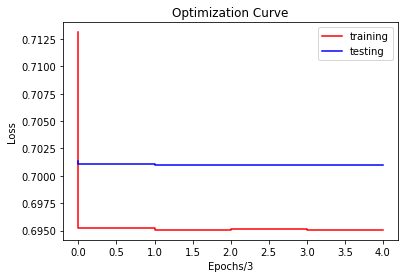

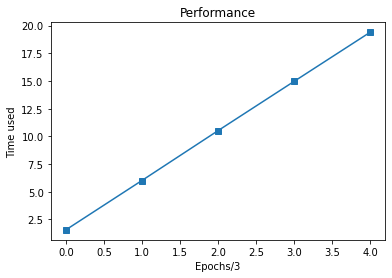

Training:
The classification rate for this dataset is 61.4%
Testing:
The classification rate for this dataset is 60.7%


In [11]:
'''from google.colab import files
src = list(files.upload().values())[0]
open('YZ_nn_training_format.py','wb').write(src)
from YZ_nn_training_format import YZ_torch_std;'''

import YZ_nn_training_format
from YZ_nn_training_format import YZ_torch_std;
model = CNN(len(vocab), 50, K_class);
STD = YZ_torch_std(model, device, train_iter, test_iter, K_class = K_class);
STD.Optimizing(lr = 1e-4, epochs = 15, plot_epoch = 3);

In [ ]:
model = CNN(len(vocab), 50, K_class);
model.to(device);

criterion = nn.BCEWithLogitsLoss(); ## Python can even return a function
#criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4);
#optimizer = torch.optim.SGD(model.parameters(),lr=1e-3, momentum = 0.5);

def batch_gd(model, criterion, optimizer, train_iter, test_iter, epochs, print_epoch = 20):
    start = time.time();
    
    train_losses = np.zeros(epochs);
    test_losses = np.zeros(epochs);

    for it in range(epochs):
        #if it%print_epoch  == 0:
            #now = time.process_time();
        
        train_loss = [];
        
        for inputs, targets in train_iter:
            #targets = targets.view(-1,1).float();
            #targets = targets.view(-1,1).int();

            targets = torch.nn.functional.one_hot(targets, K_class).float();   

            ## move data to GPU
            inputs, targets  =  inputs.to(device), targets.to(device);

            ## zero the parameter gradient
            optimizer.zero_grad();

            ## forward pass
            outputs = model(inputs);

            loss = criterion(outputs, targets);

            ## back probagation
            loss.backward();
            optimizer.step();
            train_loss.append(loss.item());

        train_loss = np.mean(train_loss);

        test_loss = [];
        for inputs, targets in test_iter:
            #targets = targets.view(-1,1).float();
            targets = torch.nn.functional.one_hot(targets, K_class).float();
            ## move data to GPU
            inputs, targets  =  inputs.to(device), targets.to(device);

            ## zero the parameter gradient
            optimizer.zero_grad();

            ## forward pass,  no need to back
            outputs = model(inputs);
            loss = criterion(outputs, targets);
            test_loss.append(loss.item());
        
        test_loss = np.mean(test_loss);

        train_losses[it] = train_loss;
        test_losses[it] = test_loss;

        if it%print_epoch  == 0:
            dt = time.time() - start;
            nn_comments = "Epoch (%d / %d)...Train_Loss: %.3e...Test_loss: %.3e...Duration: %.3e sec"\
                %(it+1, epochs, train_loss, test_loss, dt);

            Process_bar((it+1)/epochs*1.0, comments=nn_comments, overwrite = False);
    Process_bar(1.0, comments='Done!', overwrite = False);
    
    return train_losses, test_losses;

In [13]:
CNN_epochs = 15;
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_iter, test_iter, CNN_epochs,3);


Yizhou said 欲速则不达，施主稍安勿躁: | ▒▒▒▒░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ | 6.6%
Epoch (1 / 15)...Train_Loss: 7.122e-01...Test_loss: 7.013e-01...Duration: 1.498e+00 sec
Yizhou said 欲速则不达，施主稍安勿躁: | ▒▒▒▒▒▒▒▒▒▒▒▒▒▒░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ | 26.6%
Epoch (4 / 15)...Train_Loss: 6.951e-01...Test_loss: 7.010e-01...Duration: 5.973e+00 sec
Yizhou said 欲速则不达，施主稍安勿躁: | ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒░░░░░░░░░░░░░░░░░░░░░░░░░░ | 46.6%
Epoch (7 / 15)...Train_Loss: 6.951e-01...Test_loss: 7.010e-01...Duration: 1.040e+01 sec
Yizhou said 欲速则不达，施主稍安勿躁: | ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒░░░░░░░░░░░░░░░░ | 66.6%
Epoch (10 / 15)...Train_Loss: 6.954e-01...Test_loss: 7.010e-01...Duration: 1.481e+01 sec
Yizhou said 欲速则不达，施主稍安勿躁: | ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒░░░░░░ | 86.6%
Epoch (13 / 15)...Train_Loss: 6.951e-01...Test_loss: 7.010e-01...Duration: 1.927e+01 sec
Yizhou said 欲速则不达，施主稍安勿躁: | ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ | 100.0% (^_^)/ Done!
Done!

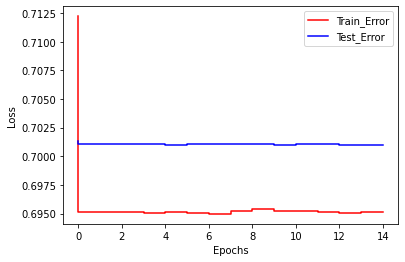

In [14]:
plt.figure();
plt.step(range(len(train_losses)),train_losses, c = 'r', label = 'Train_Error');
plt.step(range(len(test_losses)),test_losses, c = 'b', label  = 'Test_Error');
plt.legend();
plt.xlabel('Epochs');
plt.ylabel('Loss');
plt.show();

In [15]:
## Accuracy:
n_correct = 0.0;
n_total = 0.0;

for inputs, targets in train_iter:
    #targets = targets.view(-1,1).float();
    targets = torch.nn.functional.one_hot(targets, K_class).float(); 
    outputs = model(inputs);
    prediction = (torch.argmax(outputs, dim=1));

    n_total += targets.shape[0];
    n_correct += (torch.argmax(targets, dim=1) == prediction).sum().item();

train_acc = n_correct/n_total;

n_correct = 0.0;
n_total = 0.0;
for inputs, targets in test_iter:
    #targets = targets.view(-1,1).float();
    targets = torch.nn.functional.one_hot(targets, K_class).float(); 
    outputs = model(inputs);
    #prediction = (outputs > 0);
    prediction = (torch.argmax(outputs, dim=1));

    n_total += targets.shape[0];
    n_correct += (torch.argmax(targets, dim=1) == prediction).sum().item();

test_acc = n_correct/n_total;

print("Training Accuracy = %.3e \nTesting Accuracy = %.3e" %(train_acc,
                                                             test_acc));
    

Training Accuracy = 6.142e-01 
Testing Accuracy = 6.078e-01


## Pytorch Self Package

In [ ]:
path = "/content/drive/My Drive/Code Colab/Torch_Tools";
os.chdir(path);
os.listdir(path);

from YZ_torch_tools import YZ_nn_model;
from YZ_torch_tools import YZ_nn_layer;
from YZ_torch_tools import YZ_nn_optimize;

Doing a classification with 3 label(s)!

Yizhou said 欲速则不达，施主稍安勿躁: | ▒▒▒▒░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ | 6.6%
Epoch (1 / 15)...Train_Loss: 7.113e-01...                        Test_loss: 7.014e-01...Duration: 1.536e+00 sec
Yizhou said 欲速则不达，施主稍安勿躁: | ▒▒▒▒▒▒▒▒▒▒▒▒▒▒░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ | 26.6%
Epoch (4 / 15)...Train_Loss: 6.951e-01...                        Test_loss: 7.011e-01...Duration: 6.031e+00 sec
Yizhou said 欲速则不达，施主稍安勿躁: | ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒░░░░░░░░░░░░░░░░░░░░░░░░░░ | 46.6%
Epoch (7 / 15)...Train_Loss: 6.951e-01...                        Test_loss: 7.010e-01...Duration: 1.055e+01 sec
Yizhou said 欲速则不达，施主稍安勿躁: | ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒░░░░░░░░░░░░░░░░ | 66.6%
Epoch (10 / 15)...Train_Loss: 6.950e-01...                        Test_loss: 7.010e-01...Duration: 1.509e+01 sec
Yizhou said 欲速则不达，施主稍安勿躁: | ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒░░░░░░ | 86.6%
Epoch (13 / 15)...Train_Loss: 6.952e-01...                        Test_loss:

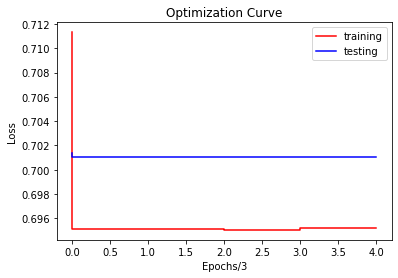

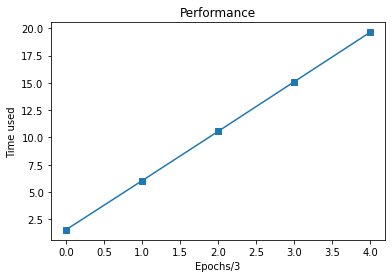

Training:
The classification rate for this dataset is 61.4%
Testing:
The classification rate for this dataset is 60.7%


In [18]:
Embed_dim = 50;
embed_layer = [["Embedding",Embed_dim]];
conv_layer = [["Permute"],["Conv1d",32,3,2],
              ["ReLU"],["Dropout", 0.25],["MaxPool1d",2],["Conv1d",64,3,2],
               ["ReLU"],["Dropout", 0.25],["MaxPool1d",2], ["Conv1d",128,3,2],
              ["ReLU"],["Dropout", 0.25],["Permute"], ["Torch_max", 1]];
ann_layer = [["Linear", 64],["ReLU"], ["Dropout", 0.25],["Linear", 32],
             ["ReLU"], ["Dropout", 0.25], ["Linear", K_class], ["Softmax"]];

LD = YZ_nn_layer(len(vocab));
LD.YZ_nn_sequential(embed_layer);
LD.YZ_nn_sequential(conv_layer);
LD.YZ_nn_sequential(ann_layer);
#LD.Show();

YZ_model = YZ_nn_model(LD.Seq);  
YZ_train = YZ_nn_optimize(YZ_model, train_iter, test_iter, K_class = K_class);
YZ_train.Optimizing(lr = 1e-4, epochs = 15, plot_epoch = 3);          

In [ ]:
print(YZ_model.layers)

In [ ]:
model